[IPython Notebook](kepler16.ipynb) |  [Python Script](kepler16.py)

Kepler 16
============================

**NOTE: triples are not supported yet - and this clearly shows why**

Setup
-----------------------------

As always, let's do imports and initialize a logger and a new bundle.  See [Building a System](../tutorials/building_a_system.html) for more details.

In [1]:
from IPython.display import Image

In [2]:
%matplotlib inline

In [3]:
import phoebe
from phoebe import u # units
import numpy as np
import matplotlib.pyplot as plt

logger = phoebe.logger(clevel='INFO')

b = phoebe.default_triple(inner_as_primary=True, starA='starA', starB='starB', starC='planet')

/usr/local/lib/python2.7/dist-packages/IPython/kernel/__init__.py:13: ShimWarning: The `IPython.kernel` package has been deprecated. You should import from ipykernel or jupyter_client instead.
  "You should import from ipykernel or jupyter_client instead.", ShimWarning)
/usr/local/lib/python2.7/dist-packages/astropy/units/quantity.py:732: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  return super(Quantity, self).__eq__(other)


In [4]:
print b.hierarchy


    orbit:outer 
    
        orbit:inner 
        
            star:starA 
            star:starB
         
        star:planet
    



System Parameters
---------------------------

Now we build the system to match all the published parameters found in Table 1 of [Doyle et al 2011](http://adsabs.harvard.edu/abs/2011Sci...333.1602D) (shown below).

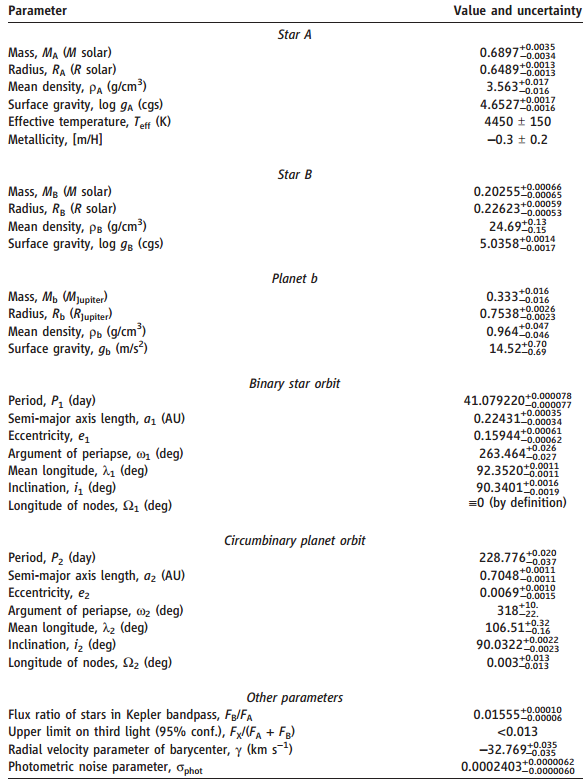

In [5]:
Image(filename='kepler16_doyle+2011table1.png', width=500)

In order to provide mean anomaly, we need to flip a few constraints.  For more information see the [constraint tutorial](../tutorials/constraints)

In [6]:
b.flip_constraint('t0_perpass@inner', solve_for='t0_supconj')
b.flip_constraint('mean_anom@inner', solve_for='t0_perpass')

<ConstraintParameter: {t0_perpass@inner@component} = {t0@system} - (({mean_anom@inner@component} * {period@inner@component}) / 6.283185307179586231995926937088) => -0.249999987778 d>

In [7]:
b.flip_constraint('t0_perpass@outer', solve_for='t0_supconj')
b.flip_constraint('mean_anom@outer', solve_for='t0_perpass')

<ConstraintParameter: {t0_perpass@outer@component} = {t0@system} - (({mean_anom@outer@component} * {period@outer@component}) / 6.283185307179586231995926937088) => -2.49999987778 d>

In [8]:
b.set_value('dict_filter@setting', {'context': 'component'})

In [9]:
b['rpole@starA'] = 0.6489 * u.solRad
b['teff@starA'] = 4450 * u.K
b['abun@starA'] = -0.3

In [10]:
b['rpole@starB'] = 0.22623 * u.solRad

In [11]:
b['rpole@planet'] = 0.7538 * 0.10045 * u.solRad

In [12]:
massA = 0.6897 * u.solMass
massB = 0.20255 * u.solMass
massPlanet = 0.333 * 0.0009543 * u.solMass
b['q@inner'] = massB/massA
b['q@outer'] = massPlanet/(massA+massB)

In [13]:
b['period@inner'] = 41.079220 * u.d
b['sma@inner'] = 0.22431 * u.AU
b['ecc@inner'] = 0.15944
mean_longitude = 92.3520 * u.deg
per0 = 263.464 * u.deg
long_an = 0 * u.deg
b['per0@inner'] = per0
b['mean_anom@inner'] = mean_longitude - per0 - long_an
b['incl@inner'] = 90.3401 * u.deg
b['long_an@inner'] = long_an

Note: we cannot directly set sma@outer as it is a constrained parameter and is ambiguous with other provided parameters.  Instead we'll check it later to make sure that the constraint results in the same value that is provided in Table 1.

In [14]:
b['period@outer'] = 228.776 * u.d
#b['sma@outer'] = 0.7048 * u.AU  # cannot set (constrained) - will check later
b['ecc@outer'] = 0.0069
mean_longitude = 106.51 * u.deg
per0 = 318.0 * u.deg
long_an = 0.003 * u.deg
b['per0@outer'] = per0
b['mean_anom@outer'] = mean_longitude - per0 - long_an
b['incl@outer'] = 90.0322 * u.deg
b['long_an@outer'] = long_an

sma@outer was automatically determined by constraints to make sure the hierarchical orbit obeyed Kepler's third laws, but let's just check to make sure it matches the value in Table 1 (0.7048 AU)

In [15]:
print "outer sma: {} ({})".format(b['sma@outer'].get_quantity(unit=u.AU), 0.7048 * u.AU)

outer sma: 0.704825072553 AU (0.7048 AU)


We'll also check to make sure the masses which were computed by Kepler's third law match those provided in the table.

In [16]:
print "mass of starA: {} ({})".format(b['mass@starA'].get_quantity(unit=u.solMass), massA)
print "mass of starB: {} ({})".format(b['mass@starB'].get_quantity(unit=u.solMass), massB)
print "mass of planet: {} ({})".format(b['mass@planet'].get_quantity(unit=u.solMass), massPlanet)

mass of starA: 0.689718787717 solMass (0.6897 solMass)
mass of starB: 0.202555517547 solMass (0.20255 solMass)
mass of planet: 0.000317766359491 solMass (0.0003177819 solMass)


In [17]:
b.set_value('dict_filter@setting', {})

In [18]:
#b['vgamma@system'] = -32.769 * u.km/u.s

The system t0 is not provided in [Doyle et al 2011](http://adsabs.harvard.edu/abs/2011Sci...333.1602D), but Kepler 16 is provided as an example case in [photodynam](https://github.com/dfm/photodynam) which uses the following value.

Note: all times will therefore be in BJD-2455000

In [19]:
b['t0@system'] = 212.12316

Adding Datasets
----------------------

In [20]:
b.add_dataset('lc', times=np.linspace(170.8, 171.3, 101))
b.add_dataset('lc', times=np.linspace(273.0, 273.5, 101))
b.add_dataset('lc', times=np.linspace(425.0, 425.5, 101))
b.add_dataset('lc', times=np.linspace(-18.7, -18.2, 101))

# TODO: TESTING ONLY - REMOVE THIS
b.add_dataset('orb', times=np.linspace(170.8, 171.3, 101))
b.add_dataset('orb', times=np.linspace(273.0, 273.5, 101))
b.add_dataset('orb', times=np.linspace(425.0, 425.5, 101))
b.add_dataset('orb', times=np.linspace(-18.7, -18.2, 101))

<ParameterSet: 4 parameters | components: planet, _default, starA, starB>

In [21]:
b.set_value_all('pblum@starA', 1.0 * 4*np.pi)

In [22]:
b.set_value_all('pblum_ref@starB', 'self')
b.set_value_all('pblum@starB', 0.01555 * 4*np.pi)

In [23]:
b.set_value_all('pblum_ref@planet', 'self')
b.set_value_all('pblum@planet', 0.0)

The paper states that quadratic-limb darkening was applied, but does not explicitly state what coefficients were used.

In [24]:
b.set_value_all('ld_func', 'quadratic')
b.set_value_all('ld_coeffs', [0.5, 0.5])

Running Compute
-----------------------

In [25]:
b.add_compute('photodynam', compute='pdcompute')

<ParameterSet: 3 parameters | qualifiers: orbiterror, stepsize, enabled>

In [26]:
b.run_compute('pdcompute', model='pd')

<ParameterSet: 92 parameters | methods: ORB, LC>

In [27]:
b.add_compute('phoebe', compute='phcompute', ltte=True)

<ParameterSet: 20 parameters | qualifiers: dynamics_method, gridsize, gr, rv_method, mesh_offset, integrator, atm, enabled, ltte, rv_grav, stepsize, etv_method, maxpoints, delta, etv_tol, store_mesh, distortion_method, eclipse_alg, mesh_method, lc_method>

Even for our models that use roche for the distortion, we'll always use rotstar for the planet.

In [28]:
b['distortion_method@starA'] = 'roche'
b['distortion_method@starB'] = 'roche'
b['distortion_method@planet'] = 'rotstar'

In [29]:
b.run_compute('phcompute', dynamics_method='keplerian', model='ph_kepl_roche')

<ParameterSet: 92 parameters | methods: ORB, LC>

In [30]:
# TODO: remove BS once nbody is working correctly
b.run_compute('phcompute', dynamics_method='bs', distortion_method='rotstar', model='ph_bs_rotstar')

<ParameterSet: 92 parameters | methods: ORB, LC>

In [31]:
b.run_compute('phcompute', dynamics_method='nbody', distortion_method='rotstar', model='ph_dynam_rotstar')

<ParameterSet: 92 parameters | methods: ORB, LC>

In [32]:
# TODO: remove BS once nbody is working correctly
b.run_compute('phcompute', dynamics_method='bs', model='ph_bs_roche')

<ParameterSet: 92 parameters | methods: ORB, LC>

In [33]:
#b.run_compute('phcompute', dynamics_method='nbody', model='ph_dynam_roche')

Plotting
-------------------------

We'll compare our models to [Doyle et al 2011](http://adsabs.harvard.edu/abs/2011Sci...333.1602D) Figure 1 (shown below).

In [34]:
def draw_lc_fig(model):
    fig, axs = plt.subplots(1,4, figsize=(12,3))
    lc_datasets = ['lc{:02d}'.format(i+1) for i in range(4)]
    for ax, ds in zip(axs.flatten(), lc_datasets):
        axs, artists = b.plot(dataset=ds, model=model, ax=ax)
        ax.get_xaxis().get_major_formatter().set_useOffset(False)
        if ds=='lc01':
            ax.set_xticks([170.9, 171.0, 171.1, 171.2])
            ax.set_xlim(170.8, 171.3)
        #    ax.set_ylim(0.85,1.05)
        elif ds=='lc02':
            ax.set_xticks([273.1, 273.2, 273.3, 273.4, 273.5])
            ax.set_xlim(273.0, 273.5)
        #    ax.set_ylim(0.980, 1.005)
        elif ds=='lc03':
            ax.set_xticks([425.0, 425.1, 425.2, 425.3, 425.4])
            ax.set_xlim(424.97, 425.5)
        #    ax.set_ylim(0.980, 1.005)
        elif ds=='lc04':
            ax.set_xticks([-18.6, -18.5, -18.4, -18.3, -18.2])
            ax.set_xlim(-18.65, -18.18)
        #    ax.set_ylim(0.9988, 1.0004)

In [35]:
def draw_orb_fig(model, x='xs', y='zs'):
    fig, axs = plt.subplots(1,4, figsize=(12,3))
    orb_datasets = ['orb{:02d}'.format(i+1) for i in range(4)]
    for ax, ds in zip(axs.flatten(), orb_datasets):
        axs, artists = b.plot(dataset=ds, model=model, ax=ax, x=x, y=y)


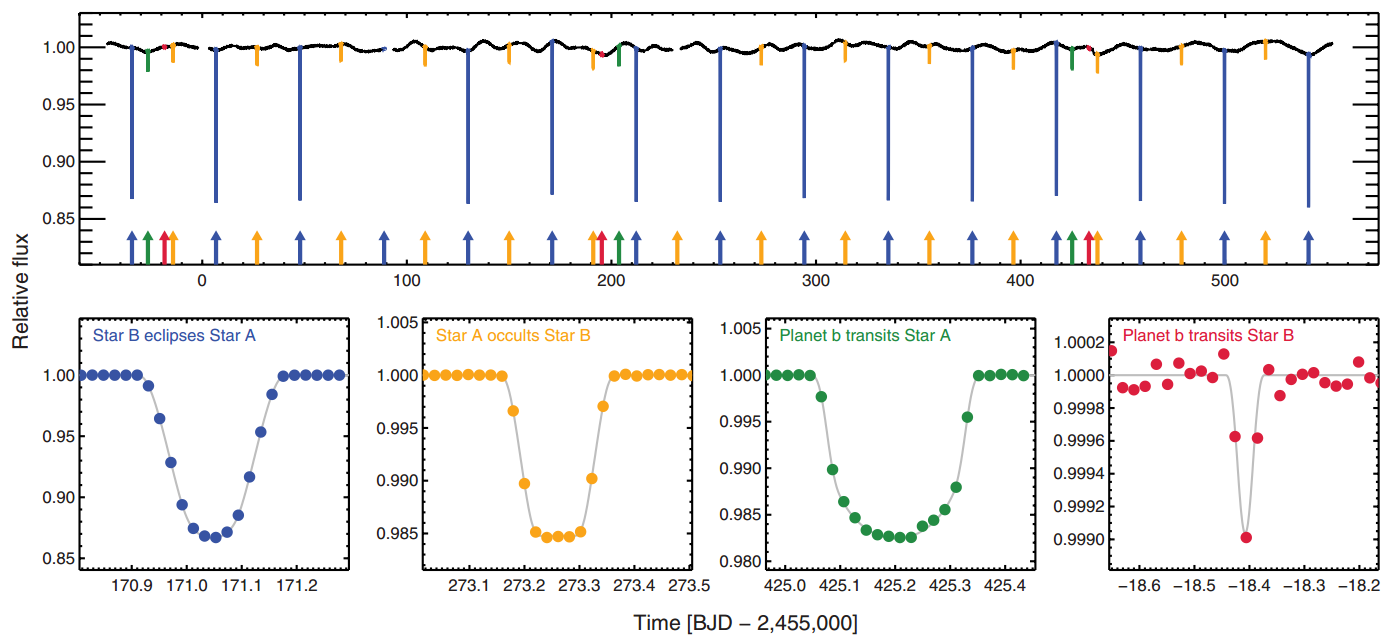

In [36]:
Image(filename='kepler16_doyle+2011fig1.png', width=850)

### Photodynam (code used in paper)

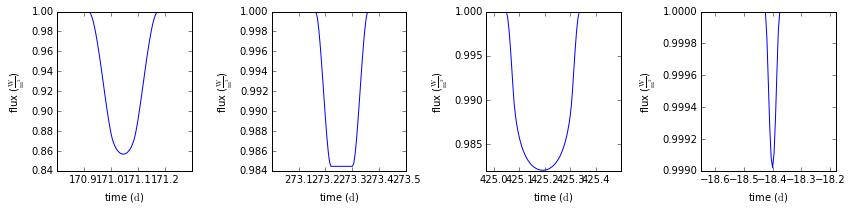

In [37]:
draw_lc_fig(model='pd')

In [48]:
#draw_orb_fig(model='pd', y='y')

### PHOEBE with keplerian & roche (rotstar for planet)

The Keplerian model manages to get the first two events correct, but misses the second two eclipse events (by not accounting for dynamical effects).

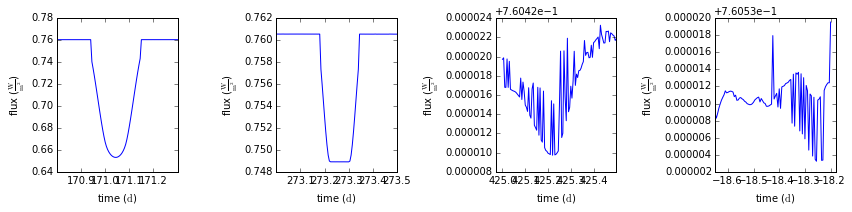

In [39]:
draw_lc_fig(model='ph_kepl_roche')

In [49]:
#draw_orb_fig(model='ph_kepl_roche', y='y')

### PHOEBE with nbody & rotstar

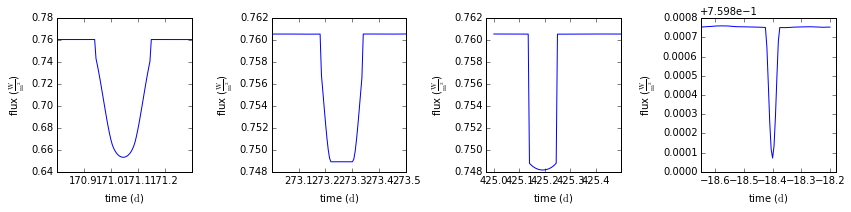

In [41]:
draw_lc_fig(model='ph_bs_rotstar')

In [50]:
#draw_orb_fig(model='ph_bs_rotstar', y='y')

In [52]:
#draw_lc_fig(model='ph_dynam_rotstar')

In [51]:
#draw_orb_fig(model='ph_dynam_rotstar', y='y')

### PHOEBE with nbody & roche (rotstar for planet)

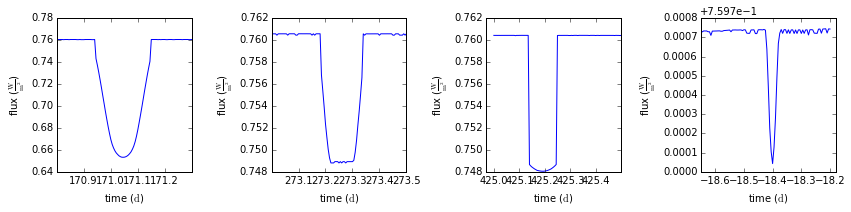

In [47]:
draw_lc_fig(model='ph_bs_roche')

In [45]:
#draw_lc_fig(model='ph_dynam_roche')